In [1]:
!pip install scikit-learn==1.5.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torchvision import models, transforms
from skimage.feature import hog

import joblib
import json

In [3]:
# ==============================
# 1. LOAD + PREPROCESS
# ==============================
def load_and_preprocess_images(
    root_dir,
    img_size=(224, 224),
    test_size=0.2,
    shuffle=True,
    random_state=168
):
    images = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    class_to_idx = {c: i for i, c in enumerate(class_names)}

    print("Class mapping:", class_to_idx)

    for cls in class_names:
        class_path = os.path.join(root_dir, cls)
        label = class_to_idx[cls]

        for fname in os.listdir(class_path):
            img_path = os.path.join(class_path, fname)

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {len(images)} images")

    X_train, X_test, y_train, y_test = train_test_split(
        images, labels,
        test_size=test_size,
        shuffle=shuffle,
        random_state=random_state,
        stratify=labels
    )

    print(f"Train size: {len(X_train)}")
    print(f"Test size:  {len(X_test)}")

    return X_train, X_test, y_train, y_test, class_to_idx

In [4]:
def extract_canny_features(images):
    canny_features = []
    for img in images:
        g = (img * 255).astype(np.uint8)
        g = cv2.cvtColor(g, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(g, 100, 200)
        canny_features.append(edges.flatten())
    return np.array(canny_features)

In [5]:
# ==============================
# 3. CONFUSION MATRIX
# ==============================
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(cm, cmap="Blues")

    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV

def train_and_evaluate(
    X_train_feat, X_test_feat, y_train, y_test, 
    class_names, name="", use_gridsearch=False, X_test_raw=None
):

    # Nếu dùng GridSearch thì tạo param grid
    if use_gridsearch:
        param_grid = {
            "n_estimators": [100, 150, 200, 250, 300],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_split": [2, 3, 4, 5]
        }

        base_clf = RandomForestClassifier(random_state=168)

        print(f"\nRunning GridSearchCV for {name}...")
        grid = GridSearchCV(
            estimator=base_clf,
            param_grid=param_grid,
            scoring="accuracy",
            cv=3,
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train_feat, y_train)
        clf = grid.best_estimator_

        print("\nBest Params:", grid.best_params_)
        print("Best CV Score:", grid.best_score_)

    else:
        clf = RandomForestClassifier(
            n_estimators=300,
            max_depth=30,
            random_state=168
        )
        clf.fit(X_train_feat, y_train)

    # Predict
    pred = clf.predict(X_test_feat)

    # Find misclassified & correct samples
    mis_idx = np.where(pred != y_test)[0]
    correct_idx = np.where(pred == y_test)[0]

    print(f"\nTotal misclassified samples: {len(mis_idx)}")

    print("\n=== CORRECTLY predicted samples ===")
    print(correct_idx[:5])
    for i in correct_idx[:5]:
        print(f"Index: {i}, Label: {class_names[y_test[i]]}")

    print("\n=== MISCLASSIFIED samples ===")
    print(mis_idx[:5])
    for i in mis_idx[:5]:
        print(f"Index: {i}, True: {class_names[y_test[i]]}, Pred: {class_names[pred[i]]}")

    # Save model
    model_path = f"{name}_rf_model.pkl"
    joblib.dump(clf, model_path)
    print(f"\nSaved model to {model_path}")

    # Evaluate
    acc = accuracy_score(y_test, pred)
    print(f"\nAccuracy ({name}): {acc:.4f}")
    print(f"\nClassification Report ({name}):\n", classification_report(y_test, pred))

    # Show images
    if X_test_raw is not None:
        print("\nShowing correct samples:")
        for i in correct_idx[:5]:
            plt.figure(figsize=(3, 3))
            plt.imshow(X_test_raw[i])
            plt.title(f"CORRECT — Label: {class_names[y_test[i]]}")
            plt.axis("off")
            plt.show()

        print("\nShowing misclassified samples:")
        for i in mis_idx[:5]:
            plt.figure(figsize=(3, 3))
            plt.imshow(X_test_raw[i])
            plt.title(f"WRONG — True: {class_names[y_test[i]]}, Pred: {class_names[pred[i]]}")
            plt.axis("off")
            plt.show()

    plot_confusion_matrix(y_test, pred, class_names, f"Confusion Matrix – {name}")
    return acc

In [7]:
root = "/kaggle/input/big-cats-image-classification-dataset/animals"

X_train, X_test, y_train, y_test, class_map = load_and_preprocess_images(
    root_dir=root,
    img_size=(224, 224),
    test_size=0.2
)
class_names = list(class_map.keys())
print("Data loaded!")

with open("class_map.json", "w") as f:
    json.dump(class_map, f)

Class mapping: {'cheetah': 0, 'leopard': 1, 'lion': 2, 'tiger': 3}
Loaded 738 images
Train size: 590
Test size:  148
Data loaded!



===== Extracting Canny features =====

Running GridSearchCV for Canny_Edge...
Fitting 3 folds for each of 140 candidates, totalling 420 fits


/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.46441520770744843

Total misclassified samples: 74

=== CORRECTLY predicted samples ===
[2 5 6 8 9]
Index: 2, Label: lion
Index: 5, Label: tiger
Index: 6, Label: cheetah
Index: 8, Label: tiger
Index: 9, Label: cheetah

=== MISCLASSIFIED samples ===
[0 1 3 4 7]
Index: 0, True: tiger, Pred: leopard
Index: 1, True: leopard, Pred: tiger
Index: 3, True: lion, Pred: leopard
Index: 4, True: lion, Pred: tiger
Index: 7, True: cheetah, Pred: tiger

Saved model to Canny_Edge_rf_model.pkl

Accuracy (Canny_Edge): 0.5000

Classification Report (Canny_Edge):
               precision    recall  f1-score   support

           0       0.58      0.49      0.53        37
           1       0.45      0.39      0.42        36
           2       0.59      0.51      0.55        37
           3       0.43      0.61      0.50        38

    accuracy                           0.50       148
   macro avg       0.51      

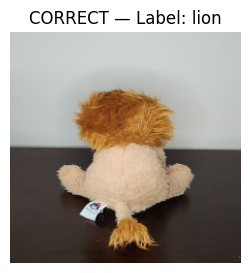

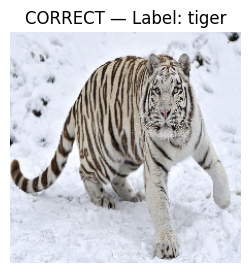

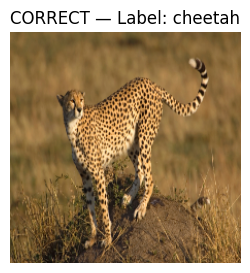

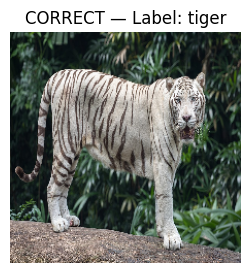

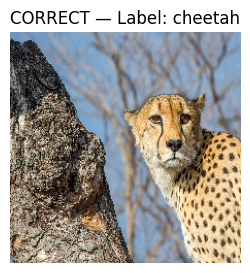


Showing misclassified samples:


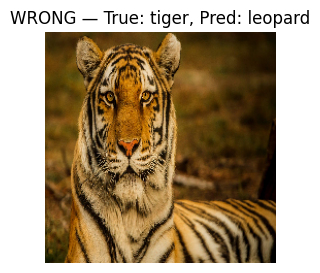

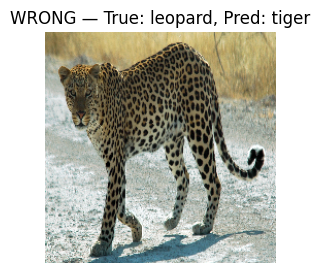

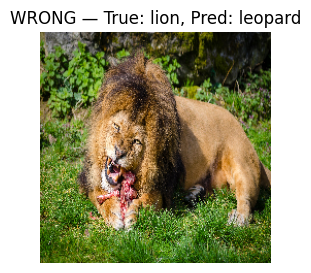

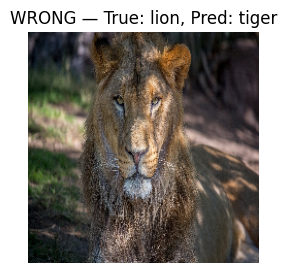

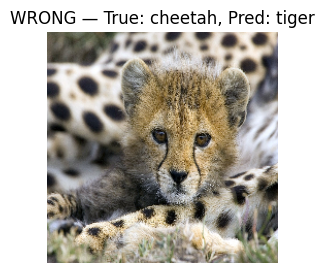

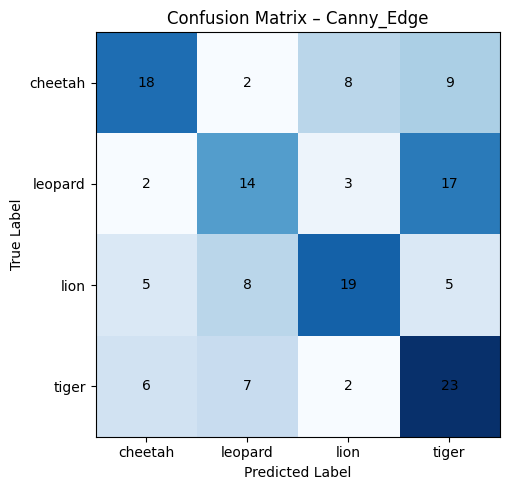

0.5

In [8]:
# === CANNY ===
print("\n===== Extracting Canny features =====")
train_canny = extract_canny_features(X_train)
test_canny = extract_canny_features(X_test)
train_and_evaluate(
    train_canny, test_canny, y_train, y_test, 
    class_names, 
    name="Canny_Edge", 
    use_gridsearch=True, 
    X_test_raw=X_test
)